In [2]:
import numpy as np                                  # type: ignore
from skimage.measure import label, regionprops      # type: ignore
from skimage.io import imread, imshow               # type: ignore
from skimage.filters import threshold_yen           # type: ignore
import glob
from dataclasses import dataclass
import napari
import os
import time as clock
import myfunctions as mf
from tqdm import tqdm

In [3]:
def mask(image, threshold):
    return np.vectorize(label, signature='(n,m)->(n,m)')(image > threshold)

# function returning the area associated to the biggest agglomerate in the sequence
def find_biggest_area(sequence, threshold):
    sequence_mask = np.zeros_like(sequence, dtype=np.ushort)
    max_area = np.zeros(sequence.shape[0])
    for i in range(sequence.shape[0]):
        sequence_mask[i,:,:] = mask(sequence[i,:,:], threshold)
        _, label_counts = np.unique(sequence_mask, return_counts=True)
        label_counts[0] = 0
        max_area[i] = np.max(label_counts)
        print(f'Slice {i}, area={max_area[i]}')
    return np.mean(max_area)

def find_threshold(sequence, threshold=0, step=1, target=5500, delta=200, slices=5):
    print('\nFinding threshold...')
    tic = clock.time()
    if len(sequence.shape) == 4:                # if the sequence is in the form (t, z, y, x), it is converted to (z, y, x)
        sequence = sequence[0,:,:,:]
    if sequence.shape[0] > slices:              # if the sequence is too long, it is reduced to n=slices slices
        sequence = np.array([sequence[i,:,:] for i in np.linspace(0, sequence.shape[0]-1, slices, dtype=int)])
    flag = False                                # flag used to stop the while loop
    add = True                                  # flag used to decide whether to add or subtract the step
    while not flag:
        current_area = find_biggest_area(sequence, threshold)
        if current_area > target + delta:       # if the area is larger than target, the threshold is increased in order to reduce the area
            if not add:
                step = step/2                   # step is halved every time the direction of the step is changed
            threshold += step
            add = True
        elif current_area < target - delta:     # if the area is smaller than target, the threshold is decreased in order to increase the area
            if add:
                step = step/2               
            threshold -= step
            add = False
        else:                                   # if the area is close to target, the threshold is found
            flag = True
        clock.sleep(1)
    toc = clock.time()
    print(f'Threshold={threshold:.2f} found in {toc-tic:.2f} s\n')
    return threshold

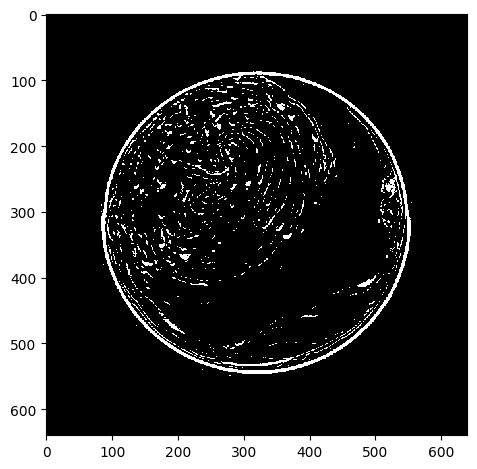

In [6]:
exp = 'P28A_FT_H_Exp1'

sequence = mf.read_3Dsequence(exp, time=150)

index_list = [0, 59, 119, 179, 239]

sequence = np.array([sequence[i,:,:] for i in np.linspace(0, sequence.shape[0]-1, 5, dtype=int)])

imshow(sequence[0,:,:]>1)

7305


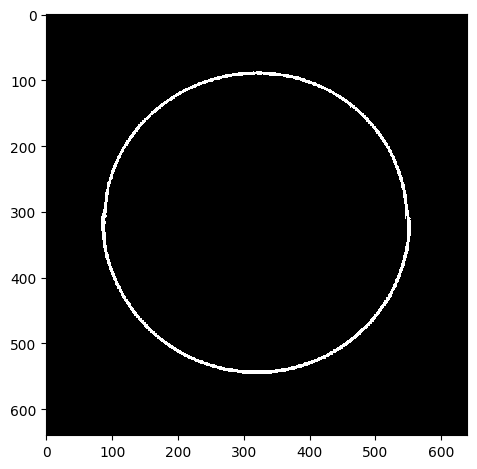

In [18]:
imshow(mask(sequence[0,:,:], 1)==1)
print(np.sum(mask(sequence[0,:,:], 1)==1))

7415


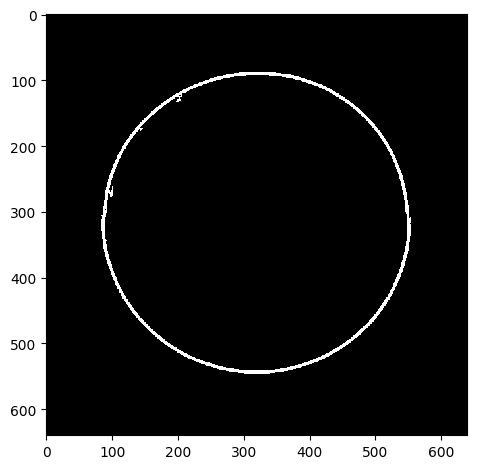

In [20]:
imshow(mask(sequence[1,:,:], 1)==1)
print(np.sum(mask(sequence[1,:,:], 1)==1))

In [10]:
find_biggest_area(sequence, 1)

Slice 0, area=7305.0
Slice 1, area=14720.0
Slice 2, area=22035.0
Slice 3, area=29410.0
Slice 4, area=36995.0


22093.0

In [21]:
sequence_mask = np.zeros_like(sequence, dtype=np.ushort)
max_area = np.zeros(sequence.shape[0])
for i in range(sequence.shape[0]):
    sequence_mask[i,:,:] = mask(sequence[i,:,:], 1)
    _, label_counts = np.unique(sequence_mask[i,:,:], return_counts=True)
    sorted_count = np.argsort(label_counts)[::-1]
    print(sorted_count[:5])
    label_counts[0] = 0
    max_area[i] = np.max(label_counts)
    print(f'Slice {i}, area={max_area[i]}')

[  0   1 989 359 805]
Slice 0, area=7305.0
[   0    1 1065  239  796]
Slice 1, area=7415.0
[   0    1  335   69 1087]
Slice 2, area=7315.0
[   0    1  958 1001  819]
Slice 3, area=7375.0
[  0   1 915 727 917]
Slice 4, area=7585.0
